In [1]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime

from sklearn.metrics import mean_squared_error
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot

C:\Users\TruProjects\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


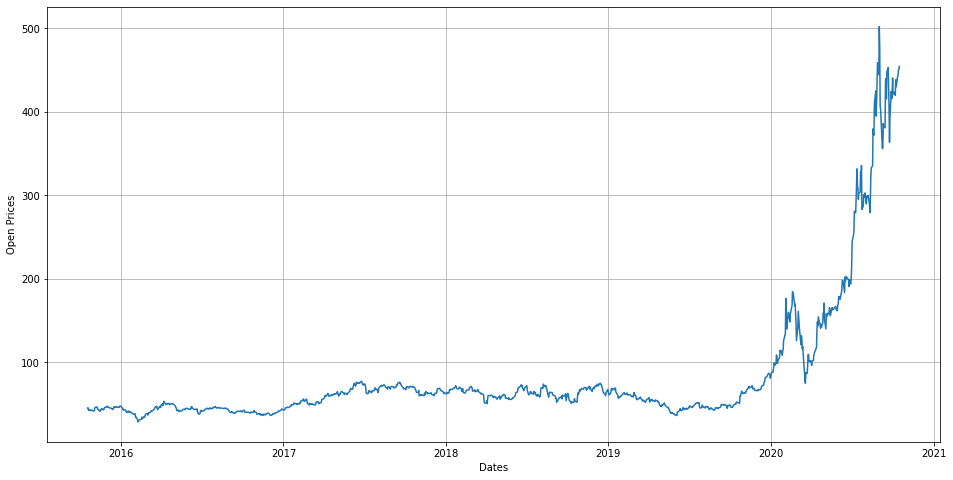

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/TSLA.csv', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open']);

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.767892
t+1  0.767892  1.000000


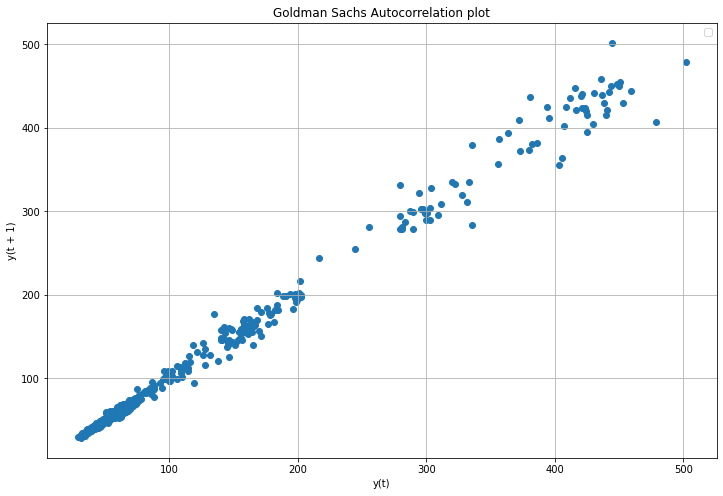

In [4]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

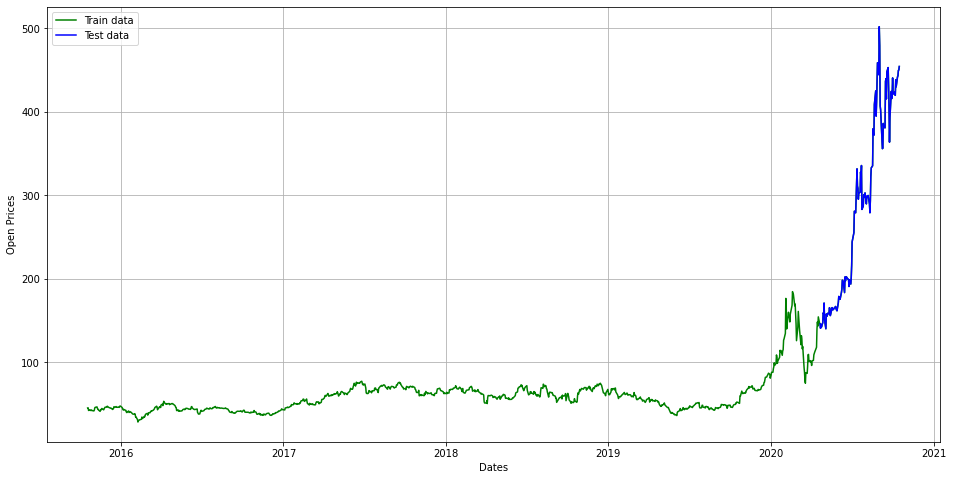

In [5]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

# LSTM

In [6]:
train = train_data.iloc[:, 0:1].values # selecting open prices

In [7]:
scaler = MinMaxScaler() #Feature Scaling
train_scaled = scaler.fit_transform(train)

In [8]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
from numpy.random import seed 
seed(2019)

In [10]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [13]:
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
36/36 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 2/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 3/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 4/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 5/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 6/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 7/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 8/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 9/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 10/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 11/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 12/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 13/40
36/36 [==============================

In [14]:
real_stock_price = test_data.iloc[:,0:1].values

In [15]:
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [16]:
test_data.shape

(126, 6)

In [17]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

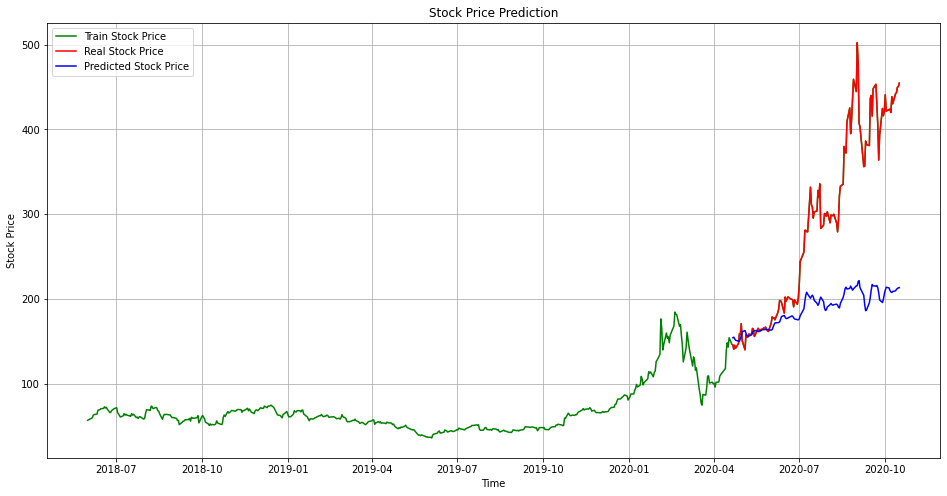

In [18]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

In [19]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

MSE: 18309.418840423372
MAE: 102.48342772279577
RMSE: 135.3123011422959


# LSTM + CPD

In [20]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [22]:
from tensorflow import keras
# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [23]:
model.fit(X_train, y_train, epochs = 40, batch_size = 32,callbacks=[early_stopping, model_checkpoint])

Epoch 1/40
36/36 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 2/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 3/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 4/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 5/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 6/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 7/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 8/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 9/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 10/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 11/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 12/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 13/40
36/36 [==============================

Epoch 25/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 26/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 27/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 28/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 29/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 30/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 31/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 32/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 33/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 34/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 35/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 36/40
36/36 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 37/40
36/36 [=====================

In [24]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [25]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

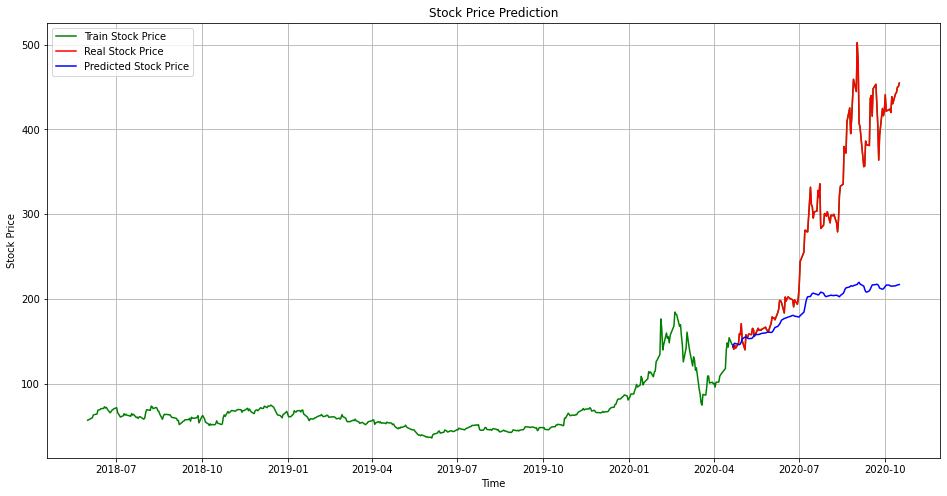

In [26]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

In [27]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

MSE: 17166.434749337186
MAE: 99.08645760781715
RMSE: 131.02074167603078


# Machine Learning  Model

In [28]:
df = pd.read_csv('data/TSLA.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null float64
High         1259 non-null float64
Low          1259 non-null float64
Close        1259 non-null float64
Adj Close    1259 non-null float64
Volume       1259 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [31]:
data = df.filter(['Close'])
dataset = data.values

In [32]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1008

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.03595933],
       [0.02954091],
       [0.02828875],
       ...,
       [0.92116456],
       [0.89471577],
       [0.87510276]])

In [34]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

In [35]:
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.03595933, 0.02954091, 0.02828875, 0.02898298, 0.02786284,
       0.03049068, 0.02839949, 0.0295111 , 0.02894465, 0.02694289,
       0.0298646 , 0.02754767, 0.03746279, 0.03752241, 0.0377737 ,
       0.03477958, 0.03101881, 0.03211766, 0.02950259, 0.02705362,
       0.03008608, 0.02995404, 0.03296521, 0.03327612, 0.03251375,
       0.0315512 , 0.03176416, 0.03661523, 0.03745427, 0.03687929,
       0.03983083, 0.03761611, 0.03792277, 0.0369304 , 0.03724984,
       0.03537159, 0.03443459, 0.03552065, 0.03124028, 0.0319047 ,
       0.03297373, 0.0386894 , 0.03821239, 0.03696447, 0.03785888,
       0.03674727, 0.03664079, 0.03701132, 0.03632136, 0.03983083,
       0.04021415, 0.04103189, 0.03396183, 0.03397035, 0.03210062,
       0.0306568 , 0.02867633, 0.02733472, 0.02823764, 0.02412338])]
[0.026623452971367048]



In [36]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [37]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]))
x_train.shape

(948, 60)

# Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)
val1 = model.score(x_train,y_train)
val1

0.9808361491205961

In [39]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9804617204447594

# Lasso Regression

In [40]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
val2 = clf.score(x_train,y_train)
val2

0.0

In [41]:
y_pred = clf.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

-1.184826486288865e+31

# Ridge regression

In [42]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(x_train,y_train)
val3 = clf.score(x_train,y_train)
val3

0.8948435386548395

In [43]:
y_pred = clf.predict(x_train)

In [44]:
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.8608956836721915

# XGBooster Regression

In [45]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(x_train,y_train)
val4 = model.score(x_train,y_train)
val4

0.9991262932837692

In [46]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9991224558480675

# Voting Regression

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , VotingRegressor

In [48]:
r1 = DecisionTreeRegressor()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = SVR(C=1.0, epsilon=0.2)
er = VotingRegressor([('dt', r1), ('rf', r2), ('sv', r3)])

In [49]:
from sklearn.model_selection import GridSearchCV
params = {'dt': [1.0, 100.0],
          'rf': [1.0, 100.0],
      'sv': [2,3,4],}
grid = GridSearchCV(estimator=er, param_grid=params, cv=2)

In [50]:
er.fit(x_train,y_train)

VotingRegressor(estimators=[('dt', DecisionTreeRegressor()),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('sv', SVR(epsilon=0.2))])

In [51]:
val5 = er.score(x_train,y_train)
val5

0.8825396818266217

In [52]:
y_pred = er.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.7343916942261474

# MLP-ANN

In [53]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=1, max_iter=500)
model.fit(x_train,y_train)
val6 = model.score(x_train,y_train)
val6

0.6532533869983793

In [54]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.8099383914639365

# Deep Learning

In [55]:
data = pd.read_csv("data/TSLA.csv")

In [56]:
data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0  2015-10-19  45.299999  46.230000  44.987999  45.619999  45.619999  12539500
1  2015-10-20  45.543999  45.720001  40.400002  42.605999  42.605999  74500000
2  2015-10-21  42.397999  42.962002  41.759998  42.018002  42.018002  20757500
3  2015-10-22  42.312000  43.150002  41.880001  42.344002  42.344002  14126000
4  2015-10-23  43.000000  43.070000  41.537998  41.818001  41.818001  21177500

In [57]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1259
Train data length : 881
Validation data lenth : 378


In [58]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

Date       Open
0   2015-10-19  45.299999
1   2015-10-20  45.543999
2   2015-10-21  42.397999
3   2015-10-22  42.312000
4   2015-10-23  43.000000
..         ...        ...
876 2019-04-12  54.043999
877 2019-04-15  53.726002
878 2019-04-16  53.150002
879 2019-04-17  54.950001
880 2019-04-18  54.245998

[881 rows x 2 columns]

In [59]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

Date        Open
881  2019-04-22   53.799999
882  2019-04-23   52.029999
883  2019-04-24   52.770000
884  2019-04-25   51.000000
885  2019-04-26   49.299999
...         ...         ...
1254 2020-10-12  442.000000
1255 2020-10-13  443.350006
1256 2020-10-14  449.779999
1257 2020-10-15  450.309998
1258 2020-10-16  454.440002

[378 rows x 2 columns]

In [60]:
dataset_train = train_data.Open.values
dataset_train.shape

(881,)

In [61]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(881, 1)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(881, 1)

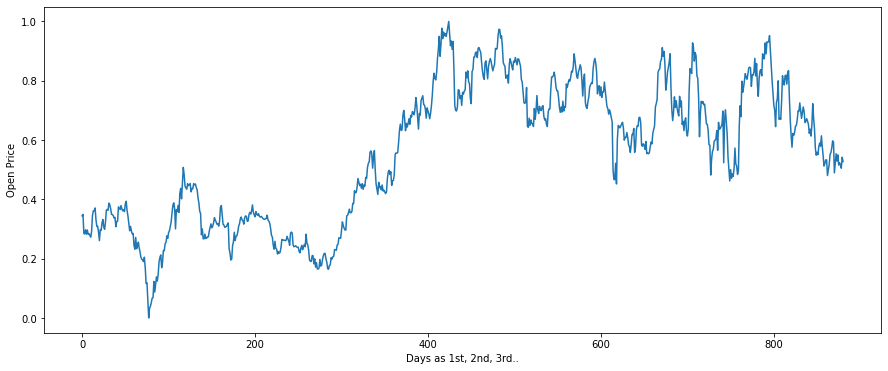

In [63]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [64]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [65]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (831, 50)
Shape of y_train before reshape : (831,)


In [66]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (831, 50, 1)
Shape of y_train after reshape : (831, 1)


# RNN

In [67]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])


In [68]:
# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
26/26 [==============================] - 1s 44ms/step - loss: 0.4270 - accuracy: 0.0012
Epoch 2/100
26/26 [==============================] - 1s 38ms/step - loss: 0.2690 - accuracy: 0.0012
Epoch 3/100
26/26 [==============================] - 1s 37ms/step - loss: 0.2261 - accuracy: 0.0024
Epoch 4/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1996 - accuracy: 0.0012
Epoch 5/100
26/26 [==============================] - 1s 40ms/step - loss: 0.1744 - accuracy: 0.0024
Epoch 6/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1588 - accuracy: 0.0024
Epoch 7/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1551 - accuracy: 0.0024
Epoch 8/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1335 - accuracy: 0.0012
Epoch 9/100
26/26 [==============================] - 1s 37ms/step - loss: 0.1125 - accuracy: 0.0012
Epoch 10/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1006 - accuracy: 0.0012

26/26 [==============================] - 1s 38ms/step - loss: 0.0052 - accuracy: 0.0024
Epoch 83/100
26/26 [==============================] - 1s 39ms/step - loss: 0.0057 - accuracy: 0.0024
Epoch 84/100
26/26 [==============================] - 1s 39ms/step - loss: 0.0057 - accuracy: 0.0024
Epoch 85/100
26/26 [==============================] - 1s 38ms/step - loss: 0.0054 - accuracy: 0.0024
Epoch 86/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0052 - accuracy: 0.0024
Epoch 87/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0053 - accuracy: 0.0024
Epoch 88/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0051 - accuracy: 0.0024
Epoch 89/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0051 - accuracy: 0.0024
Epoch 90/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0051 - accuracy: 0.0024
Epoch 91/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0047 - accuracy: 0.0024
Epo

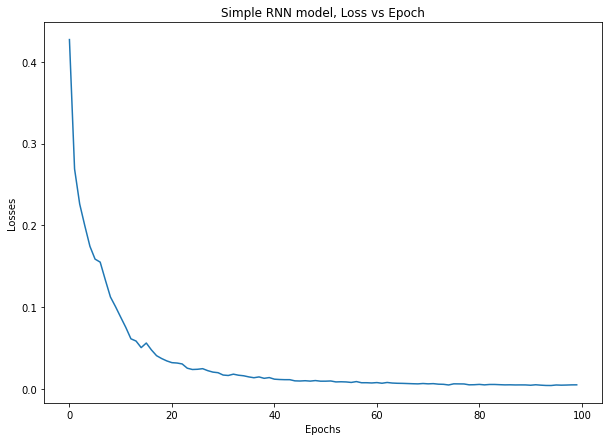

In [69]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

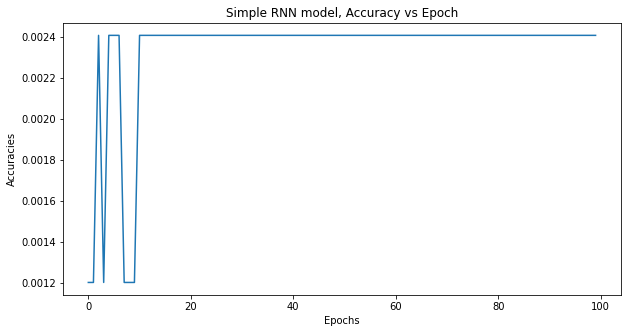

In [70]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

# CNN

In [71]:
import keras
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

In [72]:
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [73]:
# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [74]:
# sav history
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
26/26 [==============================] - 0s 6ms/step - loss: 0.1457 - mae: 0.4584
Epoch 2/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1629 - mae: 0.4973
Epoch 3/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1337 - mae: 0.4284
Epoch 4/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1232 - mae: 0.3986
Epoch 5/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1970 - mae: 0.5553
Epoch 6/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1791 - mae: 0.5432
Epoch 7/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1278 - mae: 0.4055
Epoch 8/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1258 - mae: 0.4129
Epoch 9/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.4179
Epoch 10/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.4675
Epoch 11/20
26/26 [==============================] - 0s 2ms/step - lo

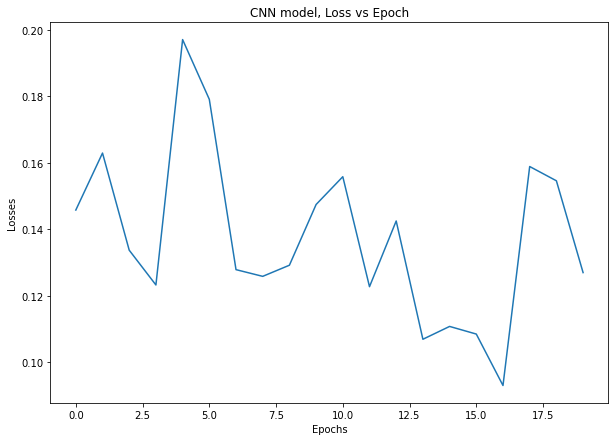

In [75]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("CNN model, Loss vs Epoch")
plt.show()

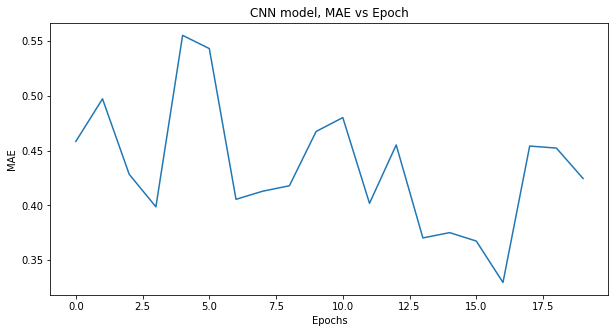

In [76]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("CNN model, MAE vs Epoch")
plt.show()

For Attention 

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [78]:
class DataLoader():
    
    def __init__(self, filename,cols):
        dataframe = pd.read_csv(filename)
        self.data_train = dataframe.get(cols).values
        self.len_train  = len(self.data_train)
        self.len_train_windows = None

    def get_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [79]:
data = DataLoader(
        "data/EURCAD_mid_price_H4.csv",
        ["close","volume"]
    )

x, y = data.get_data(
        seq_len=20,
        normalise=True
    )


In [80]:
x_train = x[:-1500]
x_test = x[-500:]
y_train = y[:-1500]
y_test = y[-500:]

# Attention+ CPD+ LSTM

In [81]:
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional

model = Sequential([
      #Bidirectional(LSTM(units=100,input_shape=(None, 2), return_sequences=True)),              
      LSTM(units=100,input_shape=(19, 2), return_sequences=True),
      Dropout(0.2),
      LSTM(units=100,return_sequences=True),
      LSTM(units=50,return_sequences=True),
      Dropout(0.2),
      Attention(),
      Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

model.fit(x_train, y_train, epochs=20,
              batch_size=32)

Epoch 1/20
770/770 [==============================] - 3s 4ms/step - loss: 1.4853e-04
Epoch 2/20
770/770 [==============================] - 3s 3ms/step - loss: 3.5575e-05
Epoch 3/20
770/770 [==============================] - 3s 3ms/step - loss: 2.8109e-05
Epoch 4/20
770/770 [==============================] - 3s 3ms/step - loss: 2.3186e-05
Epoch 5/20
770/770 [==============================] - 3s 3ms/step - loss: 1.9437e-05
Epoch 6/20
770/770 [==============================] - 3s 3ms/step - loss: 1.7502e-05
Epoch 7/20
770/770 [==============================] - 2s 3ms/step - loss: 1.5610e-05
Epoch 8/20
770/770 [==============================] - 9s 12ms/step - loss: 1.4453e-05
Epoch 9/20
770/770 [==============================] - 34s 44ms/step - loss: 1.3272e-05
Epoch 10/20
770/770 [==============================] - 159s 206ms/step - loss: 1.2843e-05
Epoch 11/20
770/770 [==============================] - 249s 323ms/step - loss: 1.1950e-05
Epoch 12/20
770/770 [==============================]

In [82]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 20 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [83]:
predictions = predict_sequences_multiple(model,x_test,19, 15)

[Model] Predicting Sequences Multiple...


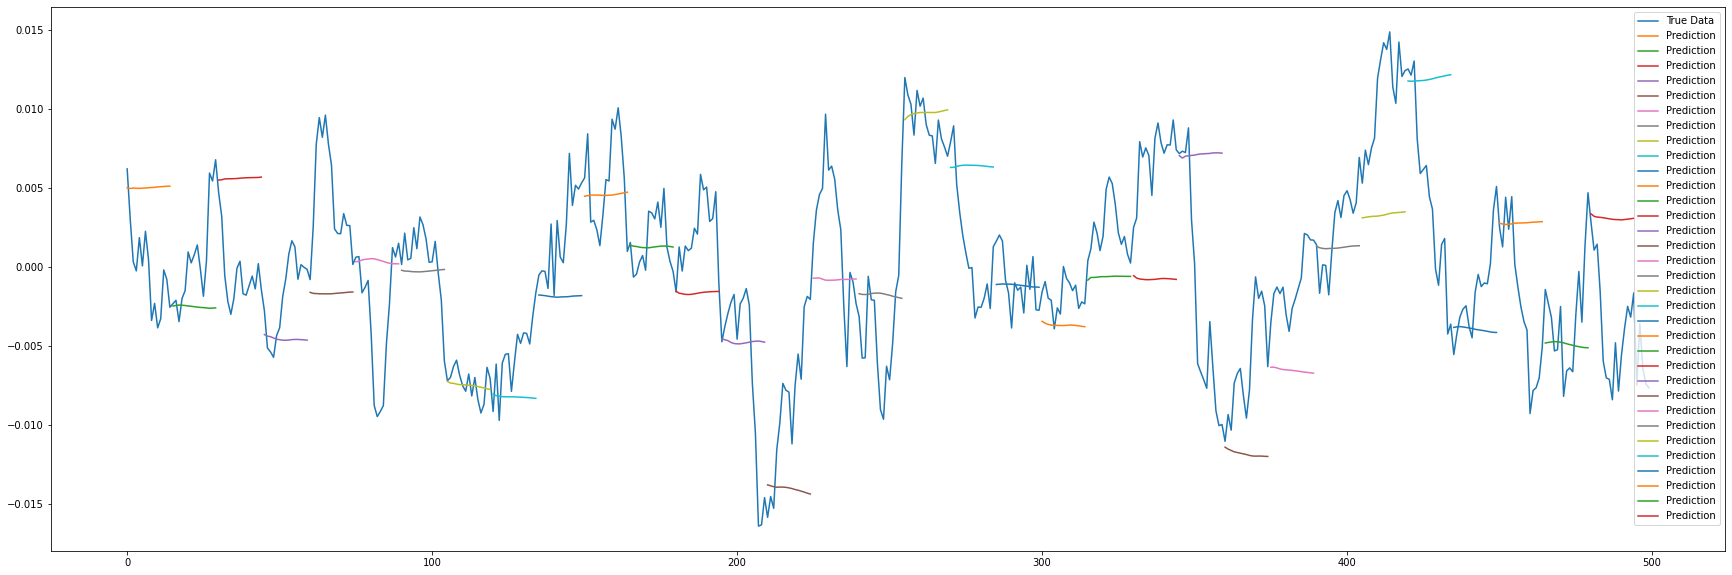

In [84]:
plt.rcParams["figure.figsize"] = [30,10]
plot_results_multiple(predictions, y_test,15)